## COORDINATE SYSTEM

목차
- Overview
- Yaw 각도의 정의

#### Overview
MMDetection3D 는 세가지 좌표계를 사용하는데, 이유는 Lidar, Depth 카메라 등과 같은 3차원 데이터 수집 센서는 서로 다른 성향의 데이터를 수집하기 때문에 각각의 좌표 시스템도 동일하지 않을 수 있기 때문이다.  
  
SECONE, VoteNet 과 같은 초창기 작업은 Raw 데이터를 다른 포맷으로 바꿨는데, 이를 후행 작업들도 따라 가게 되면서 좌표간 복잡한 변환이 일어났다.  


In [ ]:
카메라 좌표계 - 대부분의 카메라의 좌표계로, y축의 양의 방향은 지면을,  x축의 양의 방향은 오른쪽, z축의 양의 방향은 정면을 가리킨다.
           up  z front
            |    ^
            |   /
            |  /
            | /
            |/
left ------ 0 ------> x right
            |
            |
            |
            |
            v
          y down

In [ ]:
LiDAR 좌표계 – 대부분의 LiDAR의 좌표계로, 음의 z축 방향이 지면을 가리키고 x축의 양의 방향이 정면을 가리키며 y축의 양의 방향이 왼쪽을 가리킨다.
             z up  x front
               ^    ^
               |  /
               | /
               |/
y left <------ 0 ------ right

In [ ]:
Depth 좌표계 – VoteNet, H3DNet 등에서 사용하는 좌표계로, 음의 z축 방향은 지면을 가리키고, x축의 양의 방향은 오른쪽, y축이 앞쪽을 가리킨다.
          z up  y front
            ^    ^
            |   /
            |  /
            | /
            |/
left ------ 0 ------> x right

이 튜토리얼에서 좌표계 정의는 실제로 세 개의 축을 정의하는 것 이상의 의미를 가진다. $(x, y, z, dx, dy, dz, r)$ 형식의 박스에 대해 좌표계는 상자 크기 $(dx, dy, dz)$ 및 Yaw 각도 $r$ 를 해석하는 방법도 정의한다.

세 가지 좌표계의 그림은 다음과 같다.



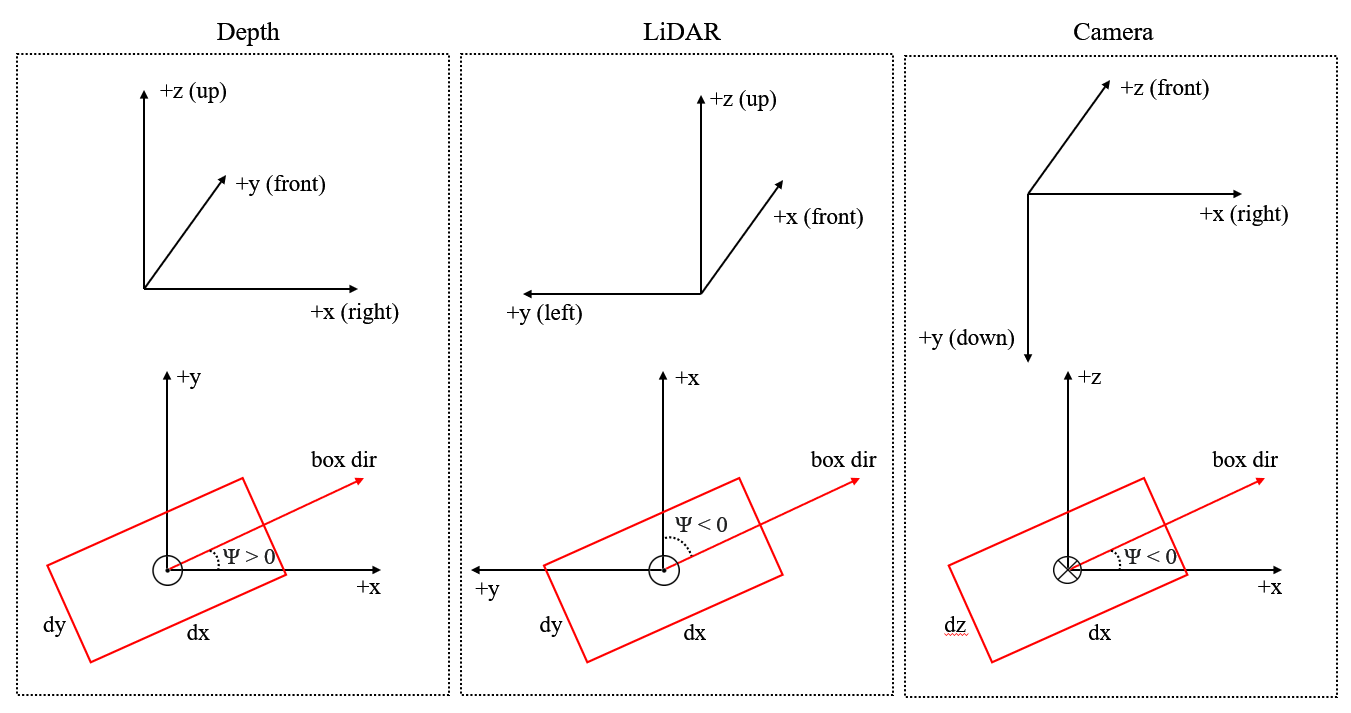

#### Yaw 각도의 정의
- 현재 지원되는 모든 데이터셋의 경우 pitch, roll 각도는 포함하지 않는다. 박스를 예측하고, 박스간 오버랩을 계산할 때 Yaw 각도가 고려한다.
- MMDetection3D에서 3가지 좌표계는 모두 오른손 좌표계이다. 즉슨, 중력의 반대 방향으로 보면 반시계 방향으로 Yaw 각도가 증가한다
- 아래 그림에 따르면 (Depth 좌표계 기준)(x축 양의 방향을 참조 축으로 설정하면) left는 yaw=180 이다.


In [ ]:
                     z up  y front (yaw=0.5*pi)
                      ^    ^
                      |   /
                      |  /
                      | /
                      |/
left (yaw=pi)  ------ 0 ------> x right (yaw=0)

박스에서 Yaw 각도는 방향에서 참조 방향을 뺀것과 같다.  
MMDetection3D의 세 좌표계 모두에서 참조 방향은 항상 x축의 양의 방향인 반면, 상자의 방향은 Yaw 각도가 0인 경우 x축과 평행하도록 정의된다.  
아래의 그림을 참조한다.

In [ ]:
y front
  ^      box direction (yaw=0.5*pi)
 /|\        ^
  |        /|\
  |     ____|____
  |    |    |    |
  |    |    |    |
__|____|____|____|______\ x right
  |    |    |    |      /
  |    |    |    |
  |    |____|____|
  |

#### 박스 차원의 정의
- 상자의 yaw 각도가 0이면 앞서 언급했듯, 상자 방향은 x축과 평행하다
- 아래의 예시를 잘 보고 축의 방향에 따라, dx, dy 를 어떻게 늘려야 박스를 조정할 수 있을지 고민해본다


아래와 같이 상자의 방향이 x축과 평행한 경우, dx는 x축 방향 상자의 크기를 나타낸다.

In [ ]:
y front
  ^     _________
 /|\   |    |    |
  |    |    |    |
  |    |    |    | dy
  |    |____|____|____\  box direction (yaw=0)
  |    |    |    |    /
__|____|____|____|_________\ x right
  |    |    |    |         /
  |    |____|____|
  |         dx
  |

아래와 같이 상자의 방향이 y축과 평행한 경우, dy가 x축 방향 상자의 크기를 나타내게 된다(!)

In [ ]:
y front
  ^      box direction (yaw=0.5*pi)
 /|\        ^
  |        /|\
  |     ____|____
  |    |    |    |
  |    |    |    | dx
__|____|____|____|______\ x right
  |    |    |    |      /
  |    |    |    |
  |    |____|____|
  |         dy

#### Relation with raw coordinate systems of supported datasets
KITTI
- KITTI의 원시 데이터는 카메라 좌표계를 따른다.
- 아래 코드를 참조한다  

In [ ]:
# https://github.com/open-mmlab/mmdetection3d/blob/1.0/tools/data_converter/kitti_data_utils.py#L117
def get_label_anno(label_path):
    annotations = {}
    annotations.update({
        'name': [],
        'truncated': [],
        'occluded': [],
        'alpha': [],
        'bbox': [],
        'dimensions': [],
        'location': [],
        'rotation_y': []
    })
    with open(label_path, 'r') as f:
        lines = f.readlines()
    content = [line.strip().split(' ') for line in lines]
    num_objects = len([x[0] for x in content if x[0] != 'DontCare']) # DontCare가 아닌것
    annotations['name'] = np.array([x[0] for x in content])
    num_gt = len(annotations['name'])
    annotations['truncated'] = np.array([float(x[1]) for x in content])
    annotations['occluded'] = np.array([int(x[2]) for x in content])
    annotations['alpha'] = np.array([float(x[3]) for x in content])
    annotations['bbox'] = np.array([[float(info) for info in x[4:8]] for x in content]).reshape(-1, 4)
    # dimensions will convert hwl format to standard lhw(camera) format.
    # 원시 좌표계를 카메라 좌표계로 둔다
    annotations['dimensions'] = np.array([[float(info) for info in x[8:11]]
                                          for x in content
                                          ]).reshape(-1, 3)[:, [2, 0, 1]]
    annotations['location'] = np.array([[float(info) for info in x[11:14]]
                                        for x in content]).reshape(-1, 3)
    annotations['rotation_y'] = np.array([float(x[14])
                                          for x in content]).reshape(-1)
    if len(content) != 0 and len(content[0]) == 16:  # have score
        annotations['score'] = np.array([float(x[15]) for x in content])
    else:
        annotations['score'] = np.zeros((annotations['bbox'].shape[0], ))
    index = list(range(num_objects)) + [-1] * (num_gt - num_objects)
    annotations['index'] = np.array(index, dtype=np.int32)
    annotations['group_ids'] = np.arange(num_gt, dtype=np.int32)
    return annotations

- MMDetection3D에서 라이다 기반 모델을 학습 시킬 때는 카메라->라이다 좌표계로 변환을 시도 한다.  
- 아래의 코드를 참조한다.

In [ ]:
#https://github.com/open-mmlab/mmdetection3d/blob/1.0/mmdet3d/datasets/kitti_dataset.py#L143
def get_ann_info(self, index):
    """Get annotation info according to the given index.

    Args:
        index (int): Index of the annotation data to get.

    Returns:
        dict: annotation information consists of the following keys:

            - gt_bboxes_3d (:obj:`LiDARInstance3DBoxes`):
                3D ground truth bboxes.
            - gt_labels_3d (np.ndarray): Labels of ground truths.
            - gt_bboxes (np.ndarray): 2D ground truth bboxes.
            - gt_labels (np.ndarray): Labels of ground truths.
            - gt_names (list[str]): Class names of ground truths.
            - difficulty (int): Difficulty defined by KITTI.
                0, 1, 2 represent xxxxx respectively.
    """
    # Use index to get the annos, thus the evalhook could also use this api
    info = self.data_infos[index]
    rect = info['calib']['R0_rect'].astype(np.float32)
    Trv2c = info['calib']['Tr_velo_to_cam'].astype(np.float32) #velodyne to camera

    if 'plane' in info:
        # convert ground plane to velodyne coordinates
        reverse = np.linalg.inv(rect @ Trv2c)
        
        (plane_norm_cam, plane_off_cam) = (info['plane'][:3], -info['plane'][:3] * info['plane'][3])
        plane_norm_lidar = (reverse[:3, :3] @ plane_norm_cam[:, None])[:, 0]
        plane_off_lidar = (reverse[:3, :3] @ plane_off_cam[:, None][:, 0] + reverse[:3, 3])
        
        plane_lidar = np.zeros_like(plane_norm_lidar, shape=(4,))
        plane_lidar[:3] = plane_norm_lidar
        plane_lidar[3] = -plane_norm_lidar.T @ plane_off_lidar
    else:
        plane_lidar = None
    
    difficulty = info['annos']['difficulty']
    annos = info['annos']
    # we need other objects to avoid collision when sample
    annos = self.remove_dontcare(annos)
    loc = annos['location']
    dims = annos['dimensions']
    rots = annos['rotation_y']
    gt_names = annos['name']
    gt_bboxes_3d = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1).astype(np.float32)

    # convert gt_bboxes_3d to velodyne coordinates
    gt_bboxes_3d = CameraInstance3DBoxes(gt_bboxes_3d).convert_to(self.box_mode_3d, np.linalg.inv(rect @ Trv2c))
    gt_bboxes = annos['bbox']
    
    selected = self.drop_arrays_by_name(gt_names, ['DontCare'])
    gt_bboxes = gt_bboxes[selected].astype('float32')
    gt_names = gt_names[selected]

    gt_labels = []
    for cat in gt_names:
        if cat in self.CLASSES:
            gt_labels.append(self.CLASSES.index(cat))
        else:
            gt_labels.append(-1)
    gt_labels = np.array(gt_labels).astype(np.int64)
    gt_labels_3d = copy.deepcopy(gt_labels)

    
    



- 카메라 기반 모델을 학습할 때는 카메라 좌표계를 유지한다.
- [SECOND](https://github.com/traveller59/second.pytorch#concepts)에서 라이다 좌표계는 아래와 같이 정의된다.
  - 각 상자의 치수는 (w, l, h)이고 Yaw 각도의 참조 방향은 y축의 양의 방향이다

- ![image.png](https://raw.githubusercontent.com/traveller59/second.pytorch/master/images/kittibox.png)

- Kitti 라이다 박스는 다음 7가지 요소로 이루어져 있다. [x, y, z, w, l, h, rz]
- SECOND에서 학습과 추론은 kitti 박스 포맷을 이용한다. 따라서, 학습 전에 kitti 박스 포맷으로 변경해야 한다.
- Kitti 카메라 박스는 다음 7가지 요소로 이루어져 있다. [x, y, z, l, h, w, ry]

우리의 Lidar 좌표계 시스템은 2가지 변경이 있다
- Yaw 각도는 (일관성을 위해) 오른손 좌표계로 정의되어 있고
- 박스 차원은 (l, w, h) 를 사용한다. (w, l, h)가 아니다. 
  - 이유는 KITTI에서 w는 dy에 l은 dx에 대응하기 때문이다.


- 아래 코드를 참조한다

#### Waymo
- KITTI와 Waymo는 동일 좌표계 시스템을 공유

#### NuScenes
- NuScene은 평가를 위한 toolkit를 제공한다. 각 박스는 Box 객체로 감싸져 있고, Box의 좌표계 시스템은 MM3D의 좌표계 시스템하고는 다르다. 첫번째 두 차원은 (dy, dx) or (w, l)에 대응된다.

#### Lyft
- Lyft는 Nuscene과 동일 좌표계 시스템 공유

#### ScanNet
- ScanNet 원본 데이터는 포인트 클라우드가 아닌 Mesh를 제공한다. Mesh 데이터는 MM3D의 Depth 좌표계와 동일하다.
- 박스 어노테이션은 축에 평행이여서, Yaw가 항상 0이다. 

#### SUN RGB-D
- SUN RGB-D의 원본 데이터는 포인트 클라우드가 아닌 RGBD 이미지이다. 
- 역투영(?)을 통해서 각 이미지를 MM3D의 Depth 좌표계로 변환할 수 있다. 

#### S3DIS
- S3DIS는 ScanNet과 동일 좌표계 공유한다. S3DIS는 Segmentation 데이터 셋이므로 좌표계에 민감한 어노테이션은 없다.

Camera 좌표계 <-> 라이다 좌표계 변환

박스 중심  
- $x_{LiDAR}=z_{camera}$

- $y_{LiDAR}=-x_{camera}$

- $z_{LiDAR}=-y_{camera}$
  
박스 차원  
- $dx_{LiDAR}=dx_{camera}$

- $dy_{LiDAR}=dz_{camera}$

- $dz_{LiDAR}=dy_{camera}$
  
Yaw 각도  
- $r_{LiDAR}=-\frac{\pi}{2}-r_{camera}$

#### Bird’s Eye View
- 카메라 좌표계의 BEV는 (x, z, dx, dz, -r) 이다
- 3D Box의 경우 카메라 좌표계의 BEV는 (x, y, z, dx, dy, dz, r) 이다.
- Yaw 각 부호가 반전되는 것은, 카메라 좌표계 중력 축의 방향이 지면을 향하고 있기 때문

#### Rotation of boxes
- 모든 종류의 상자 회전을 중력 축 기준으로 시계 반대 방향으로 설정 하였다
- 따라서, 3D 상자를 회전하려면, 새로운 박스 중심으로 계산을 하고 회전 각도를 Yaw 각도에 추가한다.


#### FAQ
Q1. 박스와 관련된 연산은 모든 좌표 시스템에 보편적으로 적용 가능한가?
- 아니다. 예를 들어 RoI-Aware Pooling ops는 Depth, Lidar 좌표계 시스템에만 적용가능하다. 
- KITTI 데이터셋 평가는 카메라 좌표계 시스템 안의 박스만 적용가능하다. 

Q2. 모든 좌표계에서 3 축은 Right, Front, Ground를 가리키고 있나?
- 아니다. KITTI에서 카메라 좌표계에서 라이다 좌표계로 변환시 Calibration 행렬이 필요하다(무슨말인지?)

#### 이하 유틸 코드

In [ ]:
# C:\DDrive\PointPillars\utils\process.py
def bbox_camera2lidar(bboxes, tr_velo_to_cam, r0_rect):
    '''
    bboxes: shape=(N, 7)
    tr_velo_to_cam: shape=(4, 4)
    r0_rect: shape=(4, 4)
    return: shape=(N, 7)    
    '''
    x_size, y_size, z_size = bboxes[:, 3:4], bboxes[:, 4:5], bboxes[:, 5:6]
    xyz_size = np.concatenate([z_size, x_size, y_size], axis=1) # (6, 3)
    # 각 박스를 (x, y, z, 1)로 만듬
    extended_xyz = np.pad(bboxes[:, :3], ((0, 0), (0, 1)), 'constant', constant_values=1.0)
    rt_mat = np.linalg.inv(r0_rect @ tr_velo_to_cam)
    xyz = extended_xyz @ rt_mat.T
    bbox_lidar = np.concatenate([xyz[:, :3], xyz_size, bboxes[:, 6:]], axis=1)
    return np.array(bbox_lidar, dtype=float)


In [ ]:
# C:\DDrive\PointPillars\utils\process.py
def bbox3d2bevcorners(bboxes):
    '''
    bboxes: shape=(n, 7)

                ^ x (-0.5 * pi)
                |
                |                (bird's eye view)
       (-pi)  o |
        y <-------------- (0)
                 \ ) (angle)
                  \ 
                   \ 

    return: shape=(n, 4, 2)
    '''
    centers, dims, angles = bboxes[:, :2], bboxes[:, 3:5], bboxes[:, 6]
    
    # 1.generate bbox corner coordinates, clockwise from minimal point
    bev_corners = np.array([[-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]], dtype=np.float32)
    bev_corners = bev_corners[None, ...] * dims[:, None, :] # (1, 4, 2) * (n, 1, 2) -> (n, 4, 2)    

    # 2. rotate
    rot_sin, rot_cos = np.sin(angles), np.cos(angles)
    # in fact, -angle
    rot_mat = np.array([[rot_cos, rot_sin], 
                        [-rot_sin, rot_cos]]) # (2, 2, n)
    rot_mat = np.transpose(rot_mat, (2, 1, 0)) # (N, 2, 2)
    bev_corners = bev_corners @ rot_mat # (n, 4, 2)

    # 3. translate to centers
    bev_corners += centers[:, None, :] 
    return bev_corners.astype(np.float32)    


In [ ]:
def remove_pts_in_bboxes(points, bboxes, rm=True):
    '''
    points: shape=(N, 3)
    bboxes: shape=(n, 7)
    return: shape=(N, n), bool
    '''

    # 1. get 6 groups of rectangle vertexs
    bboxes_corners = bbox3d2corners(bboxes) # (n, 8, 3)
    bbox_group_rectangle_vertexs = group_rectangle_vertexs(bboxes_corners) # (n, 6, 4, 3)

    # 2. calculate plane equation: ax + by + cd + d = 0
    group_plane_equation_params = group_plane_equation(bbox_group_rectangle_vertexs)

    # 3. Judge each point inside or outside the bboxes
    # if point (x0, y0, z0) lies on the direction of normal vector(a, b, c), then ax0 + by0 + cz0 + d > 0.
    masks = points_in_bboxes(points, group_plane_equation_params) # (N, n)

    if not rm:
        return masks
        
    # 4. remove point insider the bboxes
    masks = np.any(masks, axis=-1)

    return points[~masks]    


In [ ]:
def bbox3d2corners(bboxes):
    '''
    bboxes: shape=(n, 7)
    return: shape=(n, 8, 3)
           ^ z   x            6 ------ 5
           |   /             / |     / |
           |  /             2 -|---- 1 |   
    y      | /              |  |     | | 
    <------|o               | 7 -----| 4
                            |/   o   |/    
                            3 ------ 0 
    x: front, y: left, z: top
    '''
    centers, dims, angles = bboxes[:, :3], bboxes[:, 3:6], bboxes[:, 6]

    # 1.generate bbox corner coordinates, clockwise from minimal point
    bboxes_corners = np.array([[-0.5, -0.5, 0], [-0.5, -0.5, 1.0], [-0.5, 0.5, 1.0], [-0.5, 0.5, 0.0],
                               [0.5, -0.5, 0], [0.5, -0.5, 1.0], [0.5, 0.5, 1.0], [0.5, 0.5, 0.0]], 
                               dtype=np.float32)
    bboxes_corners = bboxes_corners[None, :, :] * dims[:, None, :] # (1, 8, 3) * (n, 1, 3) -> (n, 8, 3)

    # 2. rotate around z axis
    rot_sin, rot_cos = np.sin(angles), np.cos(angles)
    # in fact, -angle
    rot_mat = np.array([[rot_cos, rot_sin, np.zeros_like(rot_cos)],
                        [-rot_sin, rot_cos, np.zeros_like(rot_cos)],
                        [np.zeros_like(rot_cos), np.zeros_like(rot_cos), np.ones_like(rot_cos)]], 
                        dtype=np.float32) # (3, 3, n)          
    rot_mat = np.transpose(rot_mat, (2, 1, 0)) # (n, 3, 3)
    bboxes_corners = bboxes_corners @ rot_mat # (n, 8, 3)    
    
    # 3. translate to centers
    bboxes_corners += centers[:, None, :]
    return bboxes_corners

In [ ]:
@numba.jit(nopython=True)
def points_in_bboxes(points, plane_equation_params):
    '''
    points: shape=(N, 3)
    plane_equation_params: shape=(n, 6, 4)
    return: shape=(N, n), bool
    '''
    N, n = len(points), len(plane_equation_params)
    m = plane_equation_params.shape[1]
    masks = np.ones((N, n), dtype=np.bool_)
    for i in range(N):
        x, y, z = points[i, :3]
        for j in range(n):
            bbox_plane_equation_params = plane_equation_params[j]
            for k in range(m):
                a, b, c, d = bbox_plane_equation_params[k]
                if a * x + b * y + c * z + d >= 0:
                    masks[i][j] = False
                    break
    return masks

In [ ]:
# mmdetection3d/blob/1.0/mmdet3d/core/bbox/structures/box_3d_mode.py
from enum import IntEnum, unique

import numpy as np
import torch

from .base_box3d import BaseInstance3DBoxes
from .cam_box3d import CameraInstance3DBoxes
from .depth_box3d import DepthInstance3DBoxes
from .lidar_box3d import LiDARInstance3DBoxes
from .utils import limit_period


@unique
class Box3DMode(IntEnum):
    LIDAR = 0
    CAM = 1
    DEPTH = 2

    @staticmethod
    def convert(box, src, dst, rt_mat=None, with_yaw=True):
        """Convert boxes from `src` mode to `dst` mode.

        Args:
            box (tuple | list | np.ndarray |
                torch.Tensor | :obj:`BaseInstance3DBoxes`):
                Can be a k-tuple, k-list or an Nxk array/tensor, where k = 7.
            src (:obj:`Box3DMode`): The src Box mode.
            dst (:obj:`Box3DMode`): The target Box mode.
            rt_mat (np.ndarray | torch.Tensor, optional): The rotation and
                translation matrix between different coordinates.
                Defaults to None.
                The conversion from `src` coordinates to `dst` coordinates
                usually comes along the change of sensors, e.g., from camera
                to LiDAR. This requires a transformation matrix.
            with_yaw (bool, optional): If `box` is an instance of
                :obj:`BaseInstance3DBoxes`, whether or not it has a yaw angle.
                Defaults to True.

        Returns:
            (tuple | list | np.ndarray | torch.Tensor |
                :obj:`BaseInstance3DBoxes`):
                The converted box of the same type.
        """
        is_numpy = isinstance(box, np.ndarray)
        is_Instance3DBoxes = isinstance(box, BaseInstance3DBoxes)
        single_box = isinstance(box, (list, tuple))
        if single_box:
            assert len(box) > 7,  (
                'Box3DMode.convert takes either a k-tuple/list or '
                'an Nxk array/tensor, where k >= 7')
                arr = torch.tensor(box)[None, :]
        else:
            # avoid modifying the input box
            if is_numpy:
                arr = torch.from_numpy(np.asarray(box)).clone()
            elif is_Instance3DBoxes:
                arr = box.tensor.clone()
            else:
                arr = box.clone()

        if is_Instance3DBoxes:
            with_yaw =box.with_yaw

        # convert box from `src` mode to `dst` mode.
        x_size, y_size, z_size = arr[..., 3:4], arr[..., 4:5], arr[..., 5:6]
        if with_yaw:
            yaw = arr[..., 6:7]
        if src == Box3DMode.LIDAR and dst == Box3DMode.CAM:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[0, -1, 0], [0, 0, -1], [1, 0, 0]])
            xyz_size = torch.cat([x_size, z_size, y_size], dim=-1)
            if with_yaw:
                yaw = -yaw - np.pi / 2
                yaw = limit_period(yaw, period=np.pi * 2)
        elif src == Box3DMode.CAM and dst == Box3DMode.LIDAR:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[0, 0, 1], [-1, 0, 0], [0, -1, 0]])
            xyz_size = torch.cat([x_size, z_size, y_size], dim=-1)
            if with_yaw:
                yaw = -yaw - np.pi / 2
                yaw = limit_period(yaw, period=np.pi * 2)
        elif src == Box3DMode.DEPTH and dst == Box3DMode.CAM:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
            xyz_size = torch.cat([x_size, z_size, y_size], dim=-1)
            if with_yaw:
                yaw = -yaw
        elif src == Box3DMode.CAM and dst == Box3DMode.DEPTH:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[1, 0, 0], [0, 0, 1], [0, -1, 0]])
            xyz_size = torch.cat([x_size, z_size, y_size], dim=-1)
            if with_yaw:
                yaw = -yaw
        elif src == Box3DMode.LIDAR and dst == Box3DMode.DEPTH:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
            xyz_size = torch.cat([x_size, y_size, z_size], dim=-1)
            if with_yaw:
                yaw = yaw + np.pi / 2
                yaw = limit_period(yaw, period=np.pi * 2)
        elif src == Box3DMode.DEPTH and dst == Box3DMode.LIDAR:
            if rt_mat is None:
                rt_mat = arr.new_tensor([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
            xyz_size = torch.cat([x_size, y_size, z_size], dim=-1)
            if with_yaw:
                yaw = yaw - np.pi / 2
                yaw = limit_period(yaw, period=np.pi * 2)
        else:
            raise NotImplementedError(
                f'Conversion from Box3DMode {src} to {dst} '
                'is not supported yet')                     

        if not isinstance(rt_mat, torch.Tensor):
            rt_mat = arr.new_tensor(rt_mat)
        if rt_mat.size(1) == 4:
            extended_xyz = torch.cat(
                [arr[..., :3], arr.new_ones(arr.size(0), 1)], dim=-1)
            xyz = extended_xyz @ rt_mat.t()
        else:
            xyz = arr[..., :3] @ rt_mat.t()

        if with_yaw:
            remains = arr[..., 7:]
            arr = torch.cat([xyz[..., :3], xyz_size, yaw, remains], dim=-1)
        else:
            remains = arr[..., 6:]
            arr = torch.cat([xyz[..., :3], xyz_size, remains], dim=-1)

        # convert arr to the original type
        original_type = type(box)
        if single_box:
            return original_type(arr.flatten().tolist())
        if is_numpy:
            return arr.numpy()
        elif is_Instance3DBoxes:
            if dst == Box3DMode.CAM:
                target_type = CameraInstance3DBoxes
            elif dst == Box3DMode.LIDAR:
                target_type = LiDARInstance3DBoxes
            elif dst == Box3DMode.DEPTH:
                target_type = DepthInstance3DBoxes
            else:
                raise NotImplementedError(
                    f'Conversion to {dst} through {original_type}'
                    ' is not supported yet')
            return target_type(arr, box_dim=arr.size(-1), with_yaw=with_yaw)
        else:
            return arr

In [ ]:
class RoIAwarePool3d(nn.Module):
    """Encode the geometry-specific features of each 3D proposal.

    Please refer to `PartA2 <https://arxiv.org/pdf/1907.03670.pdf>`_ for more
    details.

    Args:
        out_size (int or tuple): The size of output features. n or
            [n1, n2, n3].
        max_pts_per_voxel (int, optional): The maximum number of points per
            voxel. Default: 128.
        mode (str, optional): Pooling method of RoIAware, 'max' or 'avg'.
            Default: 'max'.
    """
    def __init__(self,
                 out_size: Union[int, tuple],
                 max_pts_per_voxel: int = 128,
                 mode: str = 'max'):
        super().__init__()

        self.out_size = out_size
        self.max_pts_per_voxel = max_pts_per_voxel
        assert mode in ['max', 'avg']
        pool_mapping = {'max': 0, 'avg': 1}
        self.mode = pool_mapping[mode]    

    def forward(self, rois: torch.Tensor, pts: torch.Tensor, pts_feature: torch.Tensor) -> torch.Tensor:
        """
        Args:
            rois (torch.Tensor): [N, 7], in LiDAR coordinate,
                (x, y, z) is the bottom center of rois.
            pts (torch.Tensor): [npoints, 3], coordinates of input points.
            pts_feature (torch.Tensor): [npoints, C], features of input points.

        Returns:
            torch.Tensor: Pooled features whose shape is
            [N, out_x, out_y, out_z, C].
        """
        return RoIAwarePool3dFunction.apply(rois, pts, pts_feature,
                                                    self.out_size,
                                                    self.max_pts_per_voxel, self.mode)                